# Analysis of unithood

This notebook contains most parts of the analysis on unithood, the strength of association between components of concepts.

In [1]:
import utils  # a python module in the same dir as the notebooks
import seaborn as sns

In [2]:
CORPUS_NAME = 'genia'
MODEL_NAME = CORPUS_NAME + ''
MODEL_SPEC = '_min2_l10'
FREQ_THRESHOLD = 4

INCLUDE_MESH_TERMS = True
FILTER_STOP_WORDS = True
FILTER_PUNCTUATION = True

In [3]:
import os
os.chdir(utils.ROOT)  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpus
print('Loading n-gram model', flush=True)
model = ngramcounting.NgramModel.load_model(MODEL_NAME, MODEL_SPEC)

if CORPUS_NAME.lower() == 'pmc':
    corpus = dataio.load_craft_corpus() + dataio.load_genia_corpus()
else:
    corpus = dataio.load_corpus(CORPUS_NAME.lower())

Loading n-gram model
Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:14<00:00, 107.03it/s]


## Question 1: How strong is the association in regular concepts?

In [4]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False)

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries and filtered out 0 with the POS-tag filter: None


In [5]:
len(cont_concepts)

22620

In [6]:
import nltk
concept_bigrams = {bigram for concept in cont_concepts for bigram in nltk.bigrams(concept)}

In [7]:
if INCLUDE_MESH_TERMS:
    concept_bigrams.update(
    {bigram for concept in dataio.load_mesh_terms()
     for bigram in nltk.bigrams(concept)}
    )
if FILTER_STOP_WORDS:
    stopwords = set(nltk.corpus.stopwords.words('english'))
    concept_bigrams = {bg for bg in concept_bigrams
                      if not (bg[0] in stopwords or bg[1] in stopwords)}
if FILTER_PUNCTUATION:
    import string
    punct = string.punctuation
    concept_bigrams = {bg for bg in concept_bigrams
                      if not (bg[0] in punct or bg[1] in punct)}

Loading MeSH terms ...


In [64]:
import pandas as pd
import math

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'in_concept': [],  'pmi': [], 'll': [], 'tc': [], 'combo': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    combo = pmi + math.log(count, 2)
    data_dict['combo'].append(combo)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)


data = pd.DataFrame(data_dict)

In [65]:
sum(data.freq)

250767

In [66]:
# number of bigram types:
print('Outside:', len(data[data['in_concept'] == False]))
print('Inside:', len(data[data['in_concept'] == True]))

Outside: 11735
Inside: 3311


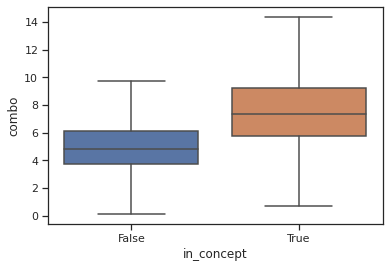

In [70]:
import seaborn as sns
sns.boxplot(x='in_concept', y='combo', data=data, showfliers=False)

In [12]:
print(utils.prepare_comparable_latex_boxplots('in_concept', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2}, xticklabels={False, True}]
\addplot+ [boxplot prepared={lower whisker=-1.88, lower quartile=0.85, median=1.64, upper quartile=2.59, upper whisker=5.43}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-1.55, lower quartile=2.98, median=4.23, upper quartile=6.00, upper whisker=10.55}] coordinates {};
\end{axis}


In [75]:
data[(data['in_concept'] == True)].sort_values('combo', ascending=False).head(10)
#  & (data['pmi'] < 0)

,bigram,in_concept,pmi,ll,tc,combo,freq
5731,"(nf-kappa, b)",True,4.989393,10979.841311,1.797796,15.062196,1077
4300,"(peripheral, blood)",True,6.661499,3448.204596,1.742202,14.667124,257
689,"(mobility, shift)",True,7.366388,2246.366068,1.694980,14.575841,148
6435,"(electrophoretic, mobility)",True,7.631869,1879.874745,1.640819,14.514512,118
4031,"(tumor, necrosis)",True,6.996076,2503.108549,1.533327,14.447287,175
4121,"(transcription, factor)",True,4.508931,8035.223502,1.435554,14.445569,980
14616,"(class, ii)",True,6.681805,2749.049100,1.518605,14.382245,208
2297,"(12-myristate, 13-acetate)",True,8.743965,904.248725,1.522634,14.328927,48
3660,"(zinc, finger)",True,8.616684,957.559923,1.512410,14.317124,52
4768,"(phorbol, ester)",True,7.375720,1818.706003,1.395424,14.270538,119


In [14]:
import re
csv_string = data[(data['in_concept'] == False)  & (data['pmi'] < 4)].sort_values('pmi', ascending=False).tail(10).to_csv(sep='&')
csv_string = csv_string.replace('&True', '')
csv_string = csv_string.replace("('", '')
csv_string = csv_string.replace("')", '')
csv_string = csv_string.replace("', '", ' ')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

	& bigram	& in_concept	& pmi	& ll	& tc	& freq\\
, of	& False	& -3.187682184908671	& 1091.7090920931369	& 0.00223028080515641	& 25\\
be cell	& False	& -3.3421198154298177	& 294.13460175805085	& 0.0004255784244617747	& 5\\
cell the	& False	& -3.375777374938518	& 567.4338860380522	& 0.0007987539438475978	& 10\\
to in	& False	& -3.403188532628918	& 315.7323694336228	& 0.00039950274596251646	& 5\\
of that	& False	& -3.618644767938719	& 336.8157470001024	& 0.00022520596299732077	& 4\\
in in	& False	& -3.86983576725388	& 622.5543055656744	& 0.0004102730669861038	& 6\\
the a	& False	& -3.884113424865242	& 634.7622904095479	& 0.0003671390659984164	& 6\\
a of	& False	& -3.9806247641071444	& 603.182402299688	& 0.00028631057401221435	& 5\\
of in	& False	& -4.031862570757471	& 961.9177508881257	& 0.0005054726016886272	& 8\\
the in	& False	& -4.20728494699921	& 1033.3691128255741	& 0.00039961402912147787	& 7\\



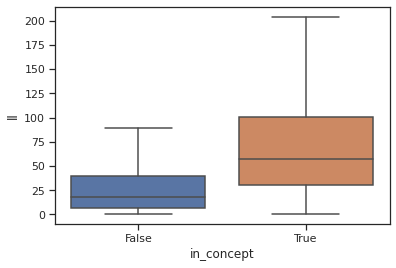

In [15]:
sns.boxplot(x='in_concept', y='ll', data=data, showfliers=False)

In [16]:
print(utils.prepare_comparable_latex_boxplots('in_concept', 'll', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2}, xticklabels={False, True}]
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=5.42, median=14.97, upper quartile=30.32, upper whisker=89.54}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=28.20, median=50.87, upper quartile=84.06, upper whisker=203.99}] coordinates {};
\end{axis}


In [17]:
data[(data['in_concept'] == True)].sort_values('ll', ascending=False).head(10)

,bigram,in_concept,pmi,ll,tc,freq
5731,"(nf-kappa, b)",True,4.989393,10979.841311,1.797796,1077
4121,"(transcription, factor)",True,4.508931,8035.223502,1.435554,980
3457,"(cell, line)",True,3.814526,4842.575513,0.515942,697
3623,"(kappa, b)",True,4.746126,4281.254823,0.829684,487
4300,"(peripheral, blood)",True,6.661499,3448.204596,1.742202,257
14616,"(class, ii)",True,6.681805,2749.049100,1.518605,208
4031,"(tumor, necrosis)",True,6.996076,2503.108549,1.533327,175
689,"(mobility, shift)",True,7.366388,2246.366068,1.694980,148
1600,"(gene, expression)",True,3.209491,2080.490195,0.437132,430
14883,"(dna, binding)",True,4.811057,2060.527566,0.631069,247


In [18]:
# we can perform t-tests etc.
import pingouin

In [19]:
t_test_result = pingouin.ttest(list(data[data['in_concept'] == True]['pmi']),
               list(data[data['in_concept'] == False]['pmi']),
               correction=True)

/home/kasper/.local/lib/python3.6/site-packages/pingouin/bayesian.py:151: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


In [20]:
t_test_result

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,64.294,4279.98,two-sided,0.0,"[2.62, 2.79]",1.53,inf,1.0


In [21]:
pingouin.compute_effsize_from_t(t_test_result['T'][0],
                                nx=len(list(data[data['in_concept'] == True]['pmi'])),
                                ny=len(list(data[data['in_concept'] == False]['pmi'])),
                                eftype='cles')

0.8145083064669394

In [22]:
pingouin.mwu(list(data[data['in_concept'] == True]['ll']),
             list(data[data['in_concept'] == False]['ll']))

,U-val,tail,p-val,RBC,CLES
MWU,29654185.0,two-sided,0.0,-0.526,0.763


Conclusion: concept bigrams _do_ have higher association.

## Question 2: How does it look for bigrams in DC's?

In [76]:
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False,
                                                    discontinuous=True)


Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries and filtered out 0 with the POS-tag filter: None


In [77]:
# extra dc's: skipgrams from CC's which are also CC's and hence a valid DC
if True:
    extra_dcs = set()
    for concept in cont_concepts:
        for sg in ngramcounting.make_skipgrams(concept):
            if sg in cont_concepts:
                print(sg)
                extra_dcs.add(sg)
    disc_concepts.update(extra_dcs)


('binding', 'site')
('transcriptional', 'activation')
('nfat', 'activation')
('transcriptional', 'activation')
('nfat', 'transcriptional', 'activation')
('human', 'cell')
('lymphoid', 'cell')
('cell', 'line')
('human', 'cell')
('lymphoid', 'cell')
('cell', 'line')
('human', 'lymphoid', 'cell')
('human', 'cell', 'line')
('lymphoid', 'cell', 'line')
('pml', 'expression')
('nuclear', 'factor')
('quiescent', 'cell')
('electrophoretic', 'mobility')
('mobility', 'assay')
('supershift', 'assay')
('electrophoretic', 'mobility')
('mobility', 'assay')
('supershift', 'assay')
('cellular', 'response')
('cellular', 'response')
('body', 'burden')
('body', 'burden')
('ets', 'family')
('s', 'phase')
('tal-1', 'promoter')
('nf-kappa', 'b')
('globin', 'promoter')
('globin', 'promoter')
('globin', 'promoter')
('zeta', '2', 'globin', 'promoter')
('stress', 'response')
('stress', 'system')
('ra', '-stimulated')
('t', 'cell')
('monoclonal', 'antibody')
('nfat', 'activation')
('nfat', 'activation')
('nfat', 

('proinflammatory', 'cytokine')
('cytokine', 'gene')
('cytokine', 'expression')
('gene', 'expression')
('proinflammatory', 'cytokine')
('cytokine', 'gene')
('cytokine', 'expression')
('gene', 'expression')
('proinflammatory', 'cytokine')
('cytokine', 'gene')
('cytokine', 'expression')
('gene', 'expression')
('proinflammatory', 'cytokine', 'gene')
('cytokine', 'gene', 'expression')
('proinflammatory', 'cytokine', 'gene')
('cytokine', 'gene', 'expression')
('proinflammatory', 'cytokine', 'gene')
('cytokine', 'gene', 'expression')
('immune', 'cell')
('immune', 'function')
('cell', 'function')
('t', 'cell')
('t', 'lymphocyte')
('myelogenous', 'leukemia')
('myelogenous', 'leukemia')
('myelogenous', 'leukemia')
('u937', 'cell')
('monocytic', 'cell')
('nf-kappa', 'b')
('nf-kappa', 'b')
('sr', '31747a')
('sr', '31747a')
('type', 'i')
('human', 'leukemia')
('t-cell', 'leukemia')
('type', 'i')
('human', 'leukemia')
('t-cell', 'leukemia')
('type', 'i')
('human', 'leukemia')
('t-cell', 'leukemia')

('chimeric', 'protein')
('nuclear', 'activity')
('nf-kb', 'activity')
('nuclear', 'activity')
('nf-kb', 'activity')
('pkc', 'activity')
('nuclear', 'activity')
('nf-kb', 'activity')
("5'-untranslated", 'leader')
("5'-untranslated", 'region')
('c-sis/platelet-derived', 'growth', 'factor-b')
('c-sis/platelet-derived', 'growth', 'factor-b')
('c-sis/platelet-derived', 'growth', 'factor-b')
('c-sis/platelet-derived', 'growth', 'factor-b')
('apoptotic', 'cell')
('breast', 'cancer')
('breast', 'cancer')
('breast', 'cancer')
('breast', 'cancer')
('pro-b', 'cell')
('pro-b', 'cell')
('pro-b', 'cell')
('murine', 'pro-b', 'cell')
('murine', 'pro-b', 'cell')
('il-3', '-dependent', 'pro-b', 'cell')
('plasma', 'cortisol')
('cortisol', 'concentration')
('blood', 'concentration')
('plasma', 'cortisol')
('cortisol', 'concentration')
('blood', 'plasma', 'cortisol')
('plasma', 'cortisol', 'concentration')
('nf-kappa', 'b')
('nf-kappa', 'b')
('t-cell', 'receptor')
('receptor', 'alpha')
('t-cell', 'receptor

('blood', 'lymphocyte')
('normal', 'human')
('normal', 'lymphocyte')
('human', 'peripheral')
('human', 'blood')
('human', 'lymphocyte')
('peripheral', 'blood')
('peripheral', 'lymphocyte')
('blood', 'lymphocyte')
('normal', 'human')
('normal', 'lymphocyte')
('human', 'peripheral')
('human', 'blood')
('human', 'lymphocyte')
('peripheral', 'blood')
('peripheral', 'lymphocyte')
('blood', 'lymphocyte')
('normal', 'human')
('normal', 'lymphocyte')
('human', 'peripheral')
('human', 'blood')
('human', 'lymphocyte')
('peripheral', 'blood')
('peripheral', 'lymphocyte')
('blood', 'lymphocyte')
('normal', 'human')
('normal', 'lymphocyte')
('human', 'peripheral')
('human', 'blood')
('human', 'lymphocyte')
('peripheral', 'blood')
('peripheral', 'lymphocyte')
('blood', 'lymphocyte')
('normal', 'human')
('normal', 'lymphocyte')
('human', 'peripheral')
('human', 'blood')
('human', 'lymphocyte')
('peripheral', 'blood')
('peripheral', 'lymphocyte')
('blood', 'lymphocyte')
('normal', 'human')
('normal', 

('t', 'cell')
('type', 'i')
('human', 'leukemia')
('t-cell', 'leukemia')
('leukemia', 'cell')
('virus-infected', 'cell')
('human', 't')
('human', 'cell')
('t', 'cell')
('type', 'i')
('human', 'leukemia')
('human', 't')
('t-cell', 'leukemia')
('leukemia', 'cell')
('virus-infected', 'cell')
('human', 't')
('human', 'cell')
('t', 'cell')
('type', 'i')
('human', 'leukemia')
('human', 't')
('human', 'cell')
('t-cell', 'leukemia')
('leukemia', 'cell')
('virus-infected', 'cell')
('human', 't')
('human', 'cell')
('t', 'cell')
('type', 'i')
('human', 'leukemia')
('human', 't')
('human', 'cell')
('t-cell', 'leukemia')
('leukemia', 'cell')
('virus-infected', 'cell')
('human', 't')
('human', 'cell')
('t', 'cell')
('type', 'i')
('human', 'leukemia')
('human', 't')
('human', 'cell')
('t-cell', 'leukemia')
('leukemia', 'cell')
('virus-infected', 'cell')
('human', 't')
('human', 'cell')
('t', 'cell')
('human', 't-cell', 'leukemia')
('human', 't', 'cell')
('human', 't-cell', 'leukemia')
('human', 't', 

('transcription', 'factor', 'nf-kappa', 'b')
('initiation', 'site')
('long', 'terminal', 'repeat')
('tyrosine', 'phosphorylation')
('tyrosine', 'phosphorylation')
('class', 'i')
('class', 'i')
('major', 'gene')
('class', 'i')
('human', 'receptor')
('interleukin', '(', 'il', ')', '-1')
('interleukin', '(', 'il', ')', '-1')
('autoimmune', 'disease')
('autoimmune', 'disease')
('autoimmune', 'disease')
('b', 'cell')
('b', 'line')
('cell', 'line')
('b', 'cell')
('b', 'line')
('cell', 'line')
('b', 'cell')
('b', 'line')
('cell', 'line')
('b', 'cell', 'line')
('b', 'cell', 'line')
('kappa', 'gene')
('retinoic', 'acid')
('receptor', 'alpha')
('human', 'receptor')
('retinoic', 'acid')
('receptor', 'alpha')
('human', 'receptor')
('retinoic', 'acid')
('receptor', 'alpha')
('retinoic', 'acid', 'receptor')
('retinoic', 'acid', 'receptor')
('retinoic', 'acid', 'receptor', 'alpha')
('regulatory', 'factor')
('regulatory', 'factor')
('t', 'cell')
('t', 'antigen')
('t', 'cell')
('t', 'antigen')
('t', 'c

('blood', 'lymphocyte')
('human', 'peripheral')
('human', 'blood')
('human', 'lymphocyte')
('peripheral', 'blood')
('peripheral', 'lymphocyte')
('blood', 'lymphocyte')
('human', 'peripheral', 'blood')
('peripheral', 'blood', 'lymphocyte')
('ut-7', 'epo')
('ut-7', 'cell')
('kappab', '-dependent', 'transcription')
('kappab', '-dependent', 'transcription')
('major', 'histocompatibility', 'complex')
('major', 'histocompatibility', 'complex')
('il-4', 'gene')
('gene', 'regulation')
('bone', 'marrow')
('cd34+', 'cell')
('bone', 'marrow')
('normal', 'cell')
('cd34+', 'cell')
('bone', 'marrow')
('bone', 'marrow', 'cell')
('bone', 'marrow', 'cell')
('normal', 'bone', 'marrow', 'cell')
('gel', 'shift')
('myeloid', 'cell')
('myeloid', 'precursor')
('amino', 'acid')
('hypersensitive', 'site')
('hs2', 'enhancer')
('hypersensitive', 'site')
('hs2', 'enhancer')
('hypersensitive', 'site')
('hs2', 'enhancer')
('hypersensitive', 'site', 'hs2', 'enhancer')
('cell', 'growth')
('cell', 'growth')
('retinoic

('e', 'box')
('recognition', 'sequence')
('t', 'cell')
('kappa', 'enhancer')
('kappa', 'enhancer')
('kappa', 'enhancer')
('kappa', 'light', 'chain')
('kappa', 'light', 'chain')
('kappa', 'light', 'chain')
('kappa', 'light', 'chain', 'enhancer')
('kappa', 'light', 'chain', 'enhancer')
('expression', 'vector')
('t', 'lymphocyte')
('t', 'lymphocyte')
('t', 'lymphocyte')
('t', 'lymphocyte')
('intracellular', 'domain')
('il-4', 'receptor')
('intracellular', 'domain')
('il-4', 'receptor')
('intracellular', 'domain')
('il-4', 'receptor')
('intracellular', 'domain')
('intracellular', 'receptor')
('il-4', 'receptor')
('differentiate', 'cell')
('myeloid', 'cell')
('differentiate', 'cell')
('myeloid', 'cell')
('terminally', 'differentiate', 'cell')
('human', 'cell')
('human', 'cell')
('human', 'cell')
('a', 'subunit')
('htlv-i', 'tax')
('tax', 'mutant')
('natural', 'killer')
('killer', 'cell')
('cell', 'line')
('natural', 'killer')
('killer', 'cell')
('cell', 'line')
('natural', 'killer', 'cell')

('nitric', 'oxide')
('type', 'i')
('nitric', 'oxide')
('type', 'i')
('nitric', 'oxide')
('nitric', 'oxide', 'synthase')
('nitric', 'oxide', 'synthase')
('nitric', 'oxide', 'synthase')
('nitric', 'oxide', 'synthase')
('nitric', 'oxide', 'synthase')
('peripheral', 'lymphocyte')
('human', 'lymphocyte')
('nf-kappa', 'b')
('nf-kappa', 'b')
('protein', 'kinase')
('kinase', 'c')
('pkc', 'inhibitor')
('protein', 'kinase')
('kinase', 'c')
('pkc', 'inhibitor')
('protein', 'kinase')
('kinase', 'c')
('pkc', 'inhibitor')
('protein', 'kinase')
('kinase', 'c')
('pkc', 'inhibitor')
('protein', 'kinase')
('kinase', 'c')
('pkc', 'inhibitor')
('protein', 'kinase', 'c')
('protein', 'kinase', 'c')
('protein', 'kinase', 'c')
('protein', 'kinase', 'c')
('protein', 'kinase', 'c', 'inhibitor')
('t', 'cell')
('binding', 'activity')
('pml/rar', 'alpha')
('pml/rar', 'alpha')
('pml/rar', 'alpha')
('pml/rar', 'alpha', 'mrna')
('pml/rar', 'alpha', 'mrna')
('1,25(oh)2d3', 'receptor')
('intracellular', 'receptor')
('t

('factor-kappa', 'b')
('nf-kappab', 'family')
('nuclear', 'nf-kappab')
('factor-kappa', 'b')
('nf-kappab', 'family')
('nuclear', 'nf-kappab')
('factor-kappa', 'b')
('nf-kappab', 'family')
('nuclear', 'nf-kappab')
('factor-kappa', 'b')
('nf-kappab', 'family')
('nuclear', 'factor-kappa', 'b')
('nuclear', 'factor-kappa', 'b')
('nuclear', 'factor-kappa', 'b')
('nuclear', 'factor-kappa', 'b')
('interleukin', '1')
('il-1', 'beta')
('beta', 'gene')
('interleukin', '1')
('il-1', 'beta')
('il-1', 'gene')
('beta', 'gene')
('interleukin', '1')
('il-1', 'beta')
('il-1', 'gene')
('beta', 'gene')
('interleukin', '1')
('beta', 'gene')
('il-1', 'beta')
('il-1', 'gene')
('beta', 'gene')
('interleukin', '1')
('beta', 'gene')
('il-1', 'beta')
('il-1', 'gene')
('beta', 'gene')
('interleukin', '1')
('beta', 'gene')
('il-1', 'beta')
('il-1', 'gene')
('beta', 'gene')
('interleukin', '1', 'beta')
('il-1', 'beta', 'gene')
('interleukin', '1', 'beta')
('il-1', 'beta', 'gene')
('interleukin', '1', 'beta')
('inte

('pleckstrin', 'homology', 'domain')
('src', 'homology', '2')
('src', 'homology', '3')
('pleckstrin', 'homology', 'domain')
('src', 'homology', '2')
('src', 'homology', '3')
('src', 'homology', '3')
('src', 'homology', '3')
('pleckstrin', 'homology', 'domain')
('src', 'homology', '2')
('src', 'homology', '3')
('src', 'homology', '3')
('src', 'homology', '3')
('pleckstrin', 'homology', 'domain')
('src', 'homology', '2')
('src', 'homology', '3')
('src', 'homology', '3')
('src', 'homology', '3')
('pleckstrin', 'homology', 'domain')
('src', 'homology', '2')
('src', 'homology', '3')
('src', 'homology', '3')
('src', 'homology', '3')
('pleckstrin', 'homology', 'domain')
('src', 'homology', '2')
('src', 'homology', '3')
('src', 'homology', '3')
('src', 'homology', '3')
('pleckstrin', 'homology', 'domain')
('src', 'homology', '2')
('src', 'homology', '3')
('src', 'homology', '3')
('src', 'homology', '3')
('pleckstrin', 'homology', 'domain')
('src', 'homology', '2', 'domain')
('blood', 'cell')
(

('v', 'beta')
('t-cell', 'receptor')
('variable', 'region')
('beta', 'chain')
('v', 'beta')
('t-cell', 'receptor')
('variable', 'region')
('beta', 'chain')
('v', 'beta')
('t-cell', 'receptor')
('variable', 'region')
('beta', 'chain')
('v', 'beta')
('t-cell', 'receptor')
('variable', 'region')
('beta', 'chain')
('v', 'beta')
('t-cell', 'receptor')
('variable', 'region', 'beta', 'chain')
('v', 'beta', 't-cell', 'receptor')
('variable', 'region', 'beta', 'chain')
('v', 'beta', 't-cell', 'receptor')
('variable', 'region', 'beta', 'chain')
('v', 'beta', 't-cell', 'receptor')
('variable', 'region', 'beta', 'chain')
('v', 'beta', 't-cell', 'receptor')
('variable', 'region', 'beta', 'chain')
('v', 'beta', 't-cell', 'receptor')
('variable', 'region', 'beta', 'chain')
('v', 'beta', 't-cell', 'receptor')
('variable', 'region', 'beta', 'chain')
('v', 'beta', 't-cell', 'receptor')
('receptor', 'complex')
('progenitor', 'cell')
('nk', 'cell')
('progenitor', 'cell')
('nk', 'cell')
('progenitor', 'cel

('factor', 'family')
('nuclear', 'factor')
('nuclear', 'factor')
('factor', 'family')
('transcription', 'factor')
('factor', 'family')
('nuclear', 'factor')
('nuclear', 'factor')
('factor', 'family')
('transcription', 'factor')
('factor', 'family')
('transcription', 'factor', 'family')
('transcription', 'factor', 'family')
('nuclear', 'transcription', 'factor')
('transcription', 'factor', 'family')
('nuclear', 'transcription', 'factor')
('transcription', 'factor', 'family')
('nuclear', 'factor', 'kappa', 'b')
('nuclear', 'factor', 'kappa', 'b')
('nuclear', 'factor', 'kappa', 'b')
('il-2', 'promoter')
('globin', 'promoter')
('globin', 'promoter')
('globin', 'promoter')
('globin', 'promoter')
('globin', 'promoter')
('zeta', '2', 'globin', 'promoter')
('zeta', '2', 'globin', 'promoter')
('zeta', '2', 'globin', 'promoter')
('b-cell', 'line')
('b-cell', 'line')
('human', 'b-cell', 'line')
('adult', 'mouse')
('adult', 'tissue')
('mouse', 'tissue')
('early', 'gene')
('early', 'gene')
('sry', 

In [78]:
dc_bigrams = {bigram for concept in disc_concepts for bigram in nltk.bigrams(concept)}

In [79]:
if FILTER_STOP_WORDS:
    stopwords = set(nltk.corpus.stopwords.words('english'))
    dc_bigrams = {bg for bg in dc_bigrams
                  if not (bg[0] in stopwords or bg[1] in stopwords)}
if FILTER_PUNCTUATION:
    import string
    punct = string.punctuation
    dc_bigrams = {bg for bg in dc_bigrams
                  if not (bg[0] in punct or bg[1] in punct)}

In [100]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'type': [],  'pmi': [], 'll': [], 'tc': [], 'combo': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    
    if bigram in concept_bigrams:
        if bigram in dc_bigrams:
            bigram_type = 'both'
        else:
            bigram_type = 'only_CC'
    elif bigram in dc_bigrams:
        continue
        bigram_type = 'only_DC'
    else:
        bigram_type = 'neither'
    data_dict['type'].append(bigram_type)
    
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    combo = pmi + math.log(count, 2)
    data_dict['combo'].append(combo)



data = pd.DataFrame(data_dict)

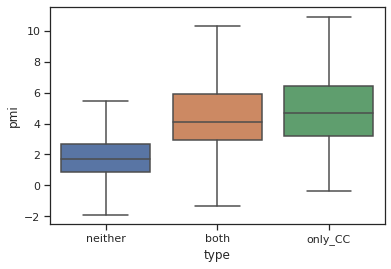

In [101]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

In [102]:
print(utils.prepare_comparable_latex_boxplots('type', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2, 3}, xticklabels={neither, only_CC, both}]
\addplot+ [boxplot prepared={lower whisker=-1.88, lower quartile=0.85, median=1.64, upper quartile=2.59, upper whisker=5.43}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-0.37, lower quartile=3.22, median=4.70, upper quartile=6.45, upper whisker=10.89}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-1.34, lower quartile=2.91, median=4.10, upper quartile=5.83, upper whisker=10.31}] coordinates {};
\end{axis}


In [103]:
pingouin.homoscedasticity(data, 'pmi', 'type')

,W,pval,equal_var
levene,365.663,8.599052e-156,False


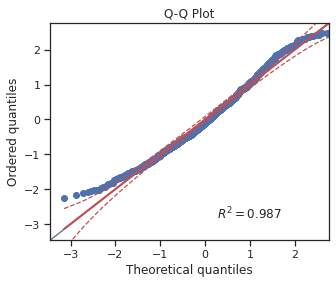

In [104]:
pingouin.qqplot(list(data[data['type'] == 'only_CC']['pmi']))

In [106]:
pingouin.welch_anova(data, 'combo', 'type')

,Source,ddof1,ddof2,F,p-unc
0,type,2,1882.61,1436.526,0.0


In [86]:
pairwise = pingouin.pairwise_gameshowell(data, 'combo', 'type', effsize='CLES')#.to_csv(sep='&')

In [87]:
pairwise

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,CLES
0,both,neither,7.637,5.047,2.591,0.038,two-sided,48.040,3175.364,0.001000,0.774
1,both,only_CC,7.637,7.377,0.261,0.069,two-sided,2.678,1501.034,0.020297,0.530
2,neither,only_CC,5.047,7.377,-2.330,0.060,two-sided,-27.354,921.825,0.001000,0.244


In [88]:
csv_string = pairwise.drop(columns=['mean(A)', 'mean(B)', 'se', 'tail', 'df']).to_csv(sep='&')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

	& A	& B	& diff	& T	& pval	& CLES\\
both	& neither	& 2.591	& 48.04	& 0.001	& 0.774\\
both	& only_CC	& 0.261	& 2.678	& 0.0202971061105498	& 0.53\\
neither	& only_CC	& -2.33	& -27.354	& 0.001	& 0.244\\



In [89]:
pingouin.compute_effsize_from_t(86.845, nx=len(list(data[data['type'] == 'neither']['pmi'])),
                                ny=len(list(data[data['type'] == 'only_CC']['pmi'])), eftype='cles')

0.985989802052797

In [90]:
data[data['type'] == 'both'].sort_values('pmi', ascending=False).head(20)

,bigram,type,pmi,ll,tc,combo,freq
11919,"(ataxia, telangiectasia)",both,10.889750,111.730402,0.602060,12.889750,4
9478,"(bw, 828)",both,10.889750,111.730402,0.602060,12.889750,4
7959,"(tetanus, toxoid)",both,10.763770,133.381513,0.698970,13.085698,5
2527,"(wound, healing)",both,10.735599,108.761367,0.535164,12.735599,4
14533,"(fluticasone, propionate)",both,10.735599,108.761367,0.535164,12.735599,4
11505,"(myocardial, infarction)",both,10.735599,108.761367,0.535164,12.735599,4
9866,"(tr2, orphan)",both,10.630239,130.125784,0.635427,12.952167,5
3631,"(raw, 264.7)",both,10.548823,175.992115,0.845098,13.356178,7
131,"(nih, 3t3)",both,10.533075,151.287741,0.718293,13.118037,6
13801,"(dimethyl, sulfoxide)",both,10.484285,104.771844,0.437862,12.484285,4


In [91]:
{bg for bg in data[data['type'] == 'only_CC']['bigram'] if bg[0] == 'bone'}

set()

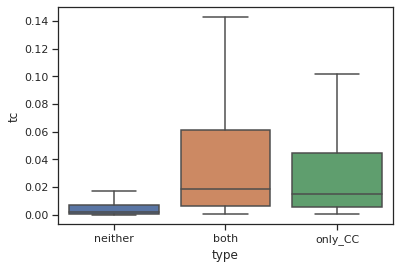

In [92]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [36]:
print(utils.prepare_comparable_latex_boxplots('type', 'll', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2, 3}, xticklabels={neither, only_CC, both}]
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=5.42, median=14.95, upper quartile=30.31, upper whisker=89.35}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=0.01, lower quartile=27.48, median=46.44, upper quartile=70.06, upper whisker=143.57}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=28.83, median=54.65, upper quartile=92.47, upper whisker=230.05}] coordinates {};
\end{axis}


In [ ]:
pingouin.

In [81]:
# However, notice that
len(data[data['type'] == 'only_DC'])

0

In [82]:
# compared to e.g.
len(data[data['type'] == 'both'])

563

## Question 3: What is the association across the gap?

In [93]:
from collections import defaultdict
from itertools import product

gap_bigrams = defaultdict(list)
cont_bigrams = defaultdict(list)
dc_sample = {dc for doc in corpus for dc in doc.get_annotations(anno.DiscontinuousConcept)}
for dc in dc_sample:
    tokens = dc.get_tokens()
    norm_concept = dc.normalized_concept()
    spanned_tokens = dc.get_spanned_tokens()
    non_dc_tokens = set(spanned_tokens).difference(tokens)
    for t in non_dc_tokens:
        if t.mapped_pos() == 'c':
            cc = t
            break
    for i in range(len(tokens) - 1):
        t1, t2 = tokens[i], tokens[i+1]
        bigram = norm_concept[i:i + 2]
        if t2.span[0] - t1.span[-1] > 2:
            gap_bigrams[bigram].append(dc)

        else:
            cont_bigrams[bigram].append(dc)

In [107]:
data_dict = {'bigram': [], 'freq': [], 'pmi': [], 'll': [], 'tc': [], 'combo': [], 'type': [], 'in_concept': []}

all_bigrams = set.union(set(gap_bigrams.keys()), set(cont_bigrams.keys()))
for bigram in all_bigrams:
    # skip if not frequent enough
    if model.freq(bigram) < FREQ_THRESHOLD:
        continue

    data_dict['bigram'].append(bigram)
    count = model.freq(bigram)
    data_dict['freq'].append(count)

    contingency_table = model.contingency_table(bigram[0], bigram[1], smoothing=1)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    tc = conceptstats.term_coherence(bigram, model)
    data_dict['tc'].append(tc)
    combo = pmi + math.log(count, 2)
    data_dict['combo'].append(combo)

    # how it occurs
    if bigram in gap_bigrams:
        if bigram in cont_bigrams: 
            type_ = 'both'
        else:
            type_ = 'only_gap'
    elif bigram in cont_bigrams:
        type_ = 'only_cont'
    else:
        type_ = 'weird'

    data_dict['type'].append(type_)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)

data = pd.DataFrame(data_dict)

### NOTE

That a bigram occurs as `only_gap` means that it occurs only in gap position for DC's. However, those bigrams can just as well occur in CC's as well, thereby getting a high association.

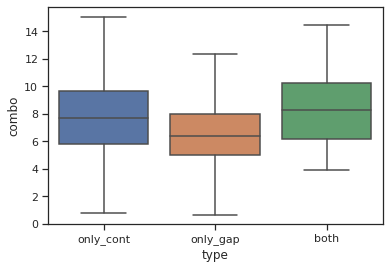

In [108]:
sns.boxplot(x='type', y='combo', data=data, showfliers=False)

In [109]:
print(utils.prepare_comparable_latex_boxplots('type', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2, 3}, xticklabels={only_cont, both, only_gap}]
\addplot+ [boxplot prepared={lower whisker=-1.32, lower quartile=2.38, median=3.42, upper quartile=4.82, upper whisker=8.71}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-0.41, lower quartile=2.43, median=3.04, upper quartile=4.49, upper whisker=7.37}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-1.26, lower quartile=2.15, median=3.12, upper quartile=4.43, upper whisker=7.85}] coordinates {};
\end{axis}


In [110]:
len(data[data['type'] == 'only_gap'])

239

In [111]:
pingouin.homoscedasticity(data, 'combo', 'type')

,W,pval,equal_var
levene,7.194,0.000809,False


In [113]:
pingouin.welch_anova(data, 'combo', 'type')

,Source,ddof1,ddof2,F,p-unc
0,type,2,160.554,25.745,2.005167e-10


In [115]:
pairwise = pingouin.pairwise_gameshowell(data, 'combo', 'type', effsize='cles')

In [116]:
pairwise

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,cles
0,both,only_cont,8.487,7.856,0.631,0.264,two-sided,1.692,78.675,0.209617,0.566
1,both,only_gap,8.487,6.585,1.901,0.265,two-sided,5.081,79.460,0.001000,0.699
2,only_cont,only_gap,7.856,6.585,1.270,0.143,two-sided,6.292,588.181,0.001000,0.642


In [ ]:
csv_string = pairwise.drop(columns=['mean(A)', 'mean(B)', 'se', 'tail', 'df']).to_csv(sep='&')
csv_string = csv_string.replace('\n', '\\\\\n')
csv_string = re.sub('\n\d+&', '\n', csv_string)
csv_string = csv_string.replace('&', '\t& ')
print(csv_string)

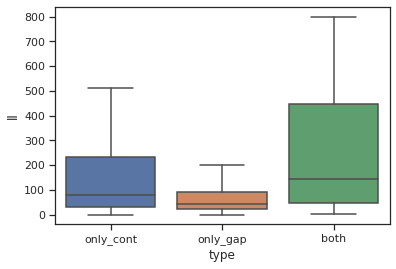

In [44]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

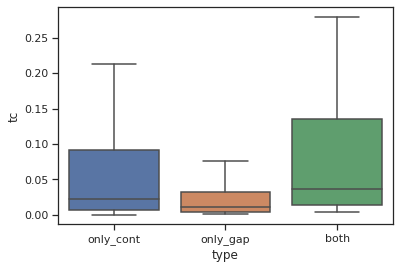

In [45]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

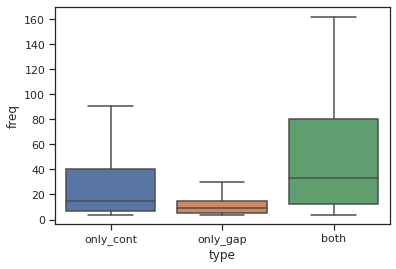

In [51]:
sns.boxplot(x='type', y='freq', data=data, showfliers=False)

## Question 4: What is the full-term unithood?

In [ ]:
all_concepts = disc_concepts.union(cont_concepts)

In [ ]:
data_dict = {'concept': [], 'type': [],  'pmi_nl': [], 'tc': [], 'freq': [], 'len': []}

for concept in all_concepts:
    
    if model[concept] < FREQ_THRESHOLD:
        continue
    
    data_dict['concept'].append(concept)
    
    data_dict['freq'].append(model[concept])
    
    if concept in disc_concepts:
        if concept in cont_concepts:
            concept_type = 'both'
        else:
            concept_type = 'only_DC'
    else:
        concept_type = 'only_CC'
    data_dict['type'].append(concept_type)
    
    data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(concept, model))
    data_dict['tc'].append(conceptstats.term_coherence(concept, model))
    
    data_dict['len'].append(len(concept))


data = pd.DataFrame(data_dict)

In [ ]:
data.sort_values('tc', ascending=False).head(50)

In [ ]:
len(data[(data['pmi_nl'] < 2) & (data['len'] == 2)]) / len(data)

In [ ]:
sns.boxplot(x='type', y='pmi_nl', data=data, showfliers=False)

In [ ]:
data_dict = {'ngram': [], 'freq': [], 'type': [], 'tc': [], 'pmi_nl': [], 'len': []}

for n in range(2, 11):
    for ngram, count in model.iterate(n, FREQ_THRESHOLD):
        
        ngram = tuple(ngram.split())

        data_dict['ngram'].append(ngram)

        data_dict['freq'].append(model[ngram])

        if ngram in disc_concepts:
            if ngram in cont_concepts:
                ngram_type = 'both'
            else:
                ngram_type = 'only_DC'
        elif ngram in cont_concepts:
            ngram_type = 'only_CC'
        else:
            ngram_type = 'neither'
            
        data_dict['type'].append(ngram_type)

        data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(ngram, model, smoothing=.1))
        data_dict['tc'].append(conceptstats.term_coherence(ngram, model))

        data_dict['len'].append(len(ngram))
        
data = pd.DataFrame(data_dict)

In [ ]:
sns.boxplot(x='type', y='pmi_nl', data=data, showfliers=False)

In [ ]:
pingouin.pairwise_ttests